(background_concepts)=
# Background and Concepts

FLORIS is a Python-based software library for calculating wind farm performance considering
the effect of turbine-turbine interactions through their wakes.
There are two primary packages that make up the software:
- `floris.simulation`: simulation framework including wake model definitions
- `floris.tools`: utilities for pre and post processing as well as driving the simulation

<!-- TODO add chart  -->

Users of FLORIS will develop a Python script with the following sequence of steps:

1. Load inputs and preprocess data
2. Run the wind farm wake calculation
3. Extract data and postprocess results

Generally, users will only interact with `floris.tools` and most often through
the `FlorisInterface` class. Additionally, `floris.tools` contains functionality
for comparing results, creating visualizations, and developing optimization cases. 

This notebook steps through the basic ideas and operations of FLORIS while showing
realistic uses and expected behavior.

## Initialize FlorisInterface

The `FlorisInterface` provides functionality to build a wind farm representation and drive
the simulation. This object is created (instantiated) by passing the path to a FLORIS input
file as the only argument. After this object is created, it can immediately be used to
inspect the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from floris.tools import FlorisInterface

fi = FlorisInterface("gch.yaml")
x, y = fi.get_turbine_layout()

print("     x       y")
for _x, _y in zip(x, y):
    print(f"{_x:6.1f}, {_y:6.1f}")

     x       y
   0.0,    0.0
 630.0,    0.0
1260.0,    0.0


## Build the model

At this point, FLORIS has been initialized with the data defined in the input file.
However, it is often simplest to define a basic configuration in the input file as
a starting point and then make modifications in the Python script. This allows for
generating data algorithmically or loading data from a data file. Modifications to
the wind farm representation are handled through the `FlorisInterface.reinitialize()`
function with keyword arguments. Another way to think of this function is that it
changes the value of inputs specified in the input file.

Let's change the location of turbines in the wind farm. The code below changes the
initial 3x1 layout to a 2x2 rectangular layout.

In [2]:
x_2x2 = [0, 0, 800, 800]
y_2x2 = [0, 400, 0, 400]
fi.reinitialize(layout_x=x_2x2, layout_y=y_2x2)

x, y = fi.get_turbine_layout()

print("     x       y")
for _x, _y in zip(x, y):
    print(f"{_x:6.1f}, {_y:6.1f}")

     x       y
   0.0,    0.0
   0.0,  400.0
 800.0,    0.0
 800.0,  400.0


Additionally, we can change the wind speeds and wind directions.
The set of wind conditions is given as arrays of wind speeds and
wind directions that combined describe the atmospheric conditions
to compute. This requires that the wind speed and wind direction
arrays be the same length.

Notice that we can give `FlorisInterface.reinitialize()` multiple keyword arguments at once.
Note that there is no expected output from the `FlorisInterface.reinitialize()` function.

In [3]:
# One wind direction and one speed
# -> one atmospheric condition (270 degrees at 8 m/s)
fi.reinitialize(wind_directions=[270.0], wind_speeds=[8.0])

# Two wind directions and one speed (repeated)
# -> two atmospheric conditions (270 degrees at 8 m/s and 280 degrees at 8 m/s)
fi.reinitialize(wind_directions=[270.0, 280.0], wind_speeds=[8.0, 8.0])

# Two wind directions and two speeds combined
# -> four atmospheric conditions (270 degrees at 8 m/s and 9 m/s, 280 degrees at 8 m/s and 9 m/s)
fi.reinitialize(wind_directions=[270.0, 280.0, 270.0, 280.0], wind_speeds=[8.0, 8.0, 9.0, 9.0])

`FlorisInterface.reinitialize()` creates all of the basic data structures required
for the simulation but it does not do any aerodynamic calculations. The low level
data structures have a complex shape that enables faster computations. Specifically,
most data is structured as a 4-dimensional Numpy array with the following dimensions:

```python
np.array(
    (
        findex,
        turbines,
        grid-1,
        grid-2
    )
)
```

The `findex` dimension contains the index to a particular calculation in the overall data
domain. This typically represents a unique combination of wind direction and wind speed
making up a wind condition, but it can also be used to represent any other varying quantity.

For example, we can see the shape of the data structure for the grid point x-coordinates
for the all turbines and get the x-coordinates of grid points for the third turbine in
the first wind condition. We can also plot all the grid points in
space to get an idea of the overall form of our grid.

Dimensions of grid x-components
(4, 4, 3, 3)

3rd turbine x-components for first wind condition (at findex=0)
[[800. 800. 800.]
 [800. 800. 800.]
 [800. 800. 800.]]


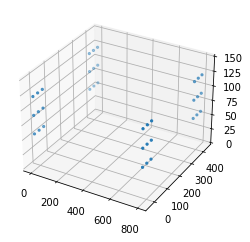

In [4]:
print("Dimensions of grid x-components")
print(np.shape(fi.floris.grid.x_sorted))

print()
print("3rd turbine x-components for first wind condition (at findex=0)")
print(fi.floris.grid.x_sorted[0, 2, :, :])

x = fi.floris.grid.x_sorted[0, :, :, :]
y = fi.floris.grid.y_sorted[0, :, :, :]
z = fi.floris.grid.z_sorted[0, :, :, :]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x, y, z, marker=".")
ax.set_zlim([0, 150])
plt.show()

## Execute wake calculation

Running the wake calculation is a one-liner. This will calculate the velocities
at each turbine given the wake of other turbines for every wind speed and wind
direction combination. Since we have not explicitly specified yaw control settings,
all turbines are aligned with the inflow.

In [5]:
fi.calculate_wake()

## Get turbine power

At this point, the simulation has completed and we can use the `FlorisInterface` to
extract useful information such as the power produced at each turbine. Remember that
we have configured the simulation with two wind directions, two wind speeds, and four
turbines.

In [6]:
powers = fi.get_turbine_powers() / 1000.0  # calculated in Watts, so convert to kW

print("Dimensions of `powers`")
print( np.shape(powers) )

N_TURBINES = fi.floris.farm.n_turbines

print()
print("Turbine powers for 8 m/s")
for i in range(2):
    print(f"Wind condition {i}")
    for j in range(N_TURBINES):
        print(f"  Turbine {j} - {powers[i, j]:7,.2f} kW")
    print()

print("Turbine powers for all turbines at all wind conditions")
print(powers)

Dimensions of `powers`
(4, 4)

Turbine powers for 8 m/s
Wind condition 0
  Turbine 0 - 1,691.33 kW
  Turbine 1 - 1,691.33 kW
  Turbine 2 -  592.65 kW
  Turbine 3 -  592.98 kW

Wind condition 1
  Turbine 0 - 1,691.33 kW
  Turbine 1 - 1,691.33 kW
  Turbine 2 - 1,631.07 kW
  Turbine 3 - 1,629.76 kW

Turbine powers for all turbines at all wind conditions
[[1691.32664838 1691.32664838  592.6531181   592.97842923]
 [1691.32664838 1691.32664838 1631.06554071 1629.75543674]
 [2407.84167188 2407.84167188  861.30649817  861.73255027]
 [2407.84167188 2407.84167188 2321.40975418 2319.53218301]]


## Applying yaw angles

Yaw angles are applied to turbines through the `FlorisInterface.calculate_wake` function.
In order to fit into the vectorized framework, the yaw settings must be represented as
a `Numpy.array` with  dimensions equal to:
- 0: findex
- 1: number of turbines

**Unlike the data configured in `FlorisInterface.reinitialize()`, yaw angles are not retained**
**in memory and must be provided each time `FlorisInterface.calculate_wake` is used.**
**If no yaw angles are given, all turbines will be aligned with the inflow.**

It is typically easiest to start with an array of 0's and modify individual
turbine yaw settings, as shown below.

In [7]:
# Recall that the previous `fi.reinitialize()` command set up four atmospheric conditions
# and there are 4 turbines in the farm.  So, the yaw angles array must be 4x4.
yaw_angles = np.zeros((4, 4))
print("Yaw angle array initialized with 0's")
print(yaw_angles)

print("First turbine yawed 25 degrees for every atmospheric condition")
yaw_angles[:, 0] = 25
print(yaw_angles)

fi.calculate_wake(yaw_angles=yaw_angles)

Yaw angle array initialized with 0's
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
First turbine yawed 25 degrees for every atmospheric condition
[[25.  0.  0.  0.]
 [25.  0.  0.  0.]
 [25.  0.  0.  0.]
 [25.  0.  0.  0.]]


## Start to finish

Let's put it all together. The code below outlines these steps:
1. Load an input file
2. Modify the inputs with a more complex wind turbine layout and additional atmospheric conditions
3. Calculate the velocities at each turbine for all atmospheric conditions
4. Get the total farm power
5. Develop the yaw control settings
6. Calculate the velocities at each turbine for all atmospheric conditions with the new yaw settings
7. Get the total farm power
8. Compare farm power with and without wake steering

In [8]:
# 1. Load an input file
fi = FlorisInterface("gch.yaml")

fi.floris.solver

# 2. Modify the inputs with a more complex wind turbine layout
D = 126.0  # Design the layout based on turbine diameter
x = [0, 0,  6 * D, 6 * D]
y = [0, 3 * D, 0, 3 * D]
wind_directions = [270.0, 280.0]
wind_speeds = [8.0, 8.0]

# Pass the new data to FlorisInterface
fi.reinitialize(
    layout_x=x,
    layout_y=y,
    wind_directions=wind_directions,
    wind_speeds=wind_speeds
)

# 3. Calculate the velocities at each turbine for all atmospheric conditions
# All turbines have 0 degrees yaw
fi.calculate_wake()

# 4. Get the total farm power
turbine_powers = fi.get_turbine_powers() / 1000.0  # Given in W, so convert to kW
farm_power_baseline = np.sum(turbine_powers, 1)  # Sum over the second dimension

# 5. Develop the yaw control settings
yaw_angles = np.zeros( (2, 4) )    # Construct the yaw array with dimensions for two wind directions, one wind speed, and four turbines
yaw_angles[0, 0] = 25           # At 270 degrees, yaw the first turbine 25 degrees
yaw_angles[0, 1] = 15           # At 270 degrees, yaw the second turbine 15 degrees
yaw_angles[1, 0] = 10           # At 280 degrees, yaw the first turbine 10 degrees
yaw_angles[1, 1] = 0            # At 280 degrees, yaw the second turbine 0 degrees

# 6. Calculate the velocities at each turbine for all atmospheric conditions with the new yaw settings
fi.calculate_wake(yaw_angles=yaw_angles)

# 7. Get the total farm power
turbine_powers = fi.get_turbine_powers() / 1000.0
farm_power_yaw = np.sum(turbine_powers, 1)

# 8. Compare farm power with and without wake steering
difference = 100 * (farm_power_yaw - farm_power_baseline) / farm_power_baseline
print("Power % difference with yaw")
print(f"    270 degrees: {difference[0]:4.2f}%")
print(f"    280 degrees: {difference[1]:4.2f}%")

Power % difference with yaw
    270 degrees: 6.43%
    280 degrees: 0.05%


## Visualization

While comparing turbine and farm powers is meaningful, a picture is worth at least
1000 Watts, and the `FlorisInterface` provides powerful routines for visualization.

The visualization functions require that the user select a single atmospheric condition
to plot. The internal data structures still have the same shape but the wind speed and
wind direction dimensions have a size of 1. This means that the yaw angle array used
for plotting must have the same shape as above but a single atmospheric condition must
be selected.

Let's create a horizontal slice of each atmospheric condition from above with and without
yaw settings included. Notice that although we are plotting the conditions for two
different wind directions, the farm is rotated so that the wind is coming from the
left (West) in both cases.

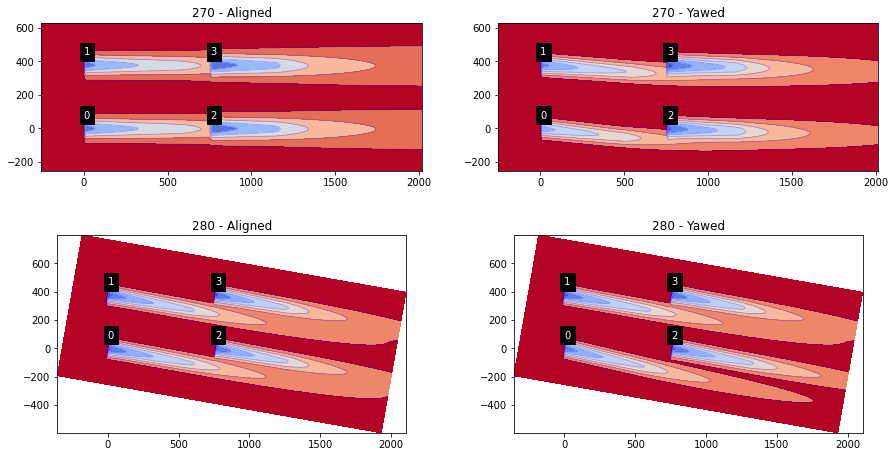

In [9]:
from floris.tools.visualization import visualize_cut_plane, add_turbine_id_labels

fig, axarr = plt.subplots(2, 2, figsize=(15,8))

# Plot the first wind condition
wd = wind_directions[0]
ws = wind_speeds[0]

horizontal_plane = fi.calculate_horizontal_plane(wd=[wd], ws=[ws], height=90.0)
visualize_cut_plane(horizontal_plane, ax=axarr[0,0], title="270 - Aligned")
add_turbine_id_labels(fi, axarr[0,0], color="w", backgroundcolor="k")

horizontal_plane = fi.calculate_horizontal_plane(wd=[wd], ws=[ws], yaw_angles=yaw_angles[0:1] , height=90.0)
visualize_cut_plane(horizontal_plane, ax=axarr[0,1], title="270 - Yawed")
add_turbine_id_labels(fi, axarr[0,1], color="w", backgroundcolor="k")

# Plot the second wind condition
wd = wind_directions[1]
ws = wind_speeds[1]

horizontal_plane = fi.calculate_horizontal_plane(wd=[wd], ws=[ws], height=90.0)
visualize_cut_plane(horizontal_plane, ax=axarr[1,0], title="280 - Aligned")
add_turbine_id_labels(fi, axarr[1,0], color="w", backgroundcolor="k")

horizontal_plane = fi.calculate_horizontal_plane(wd=[wd], ws=[ws], yaw_angles=yaw_angles[1:2] , height=90.0)
visualize_cut_plane(horizontal_plane, ax=axarr[1,1], title="280 - Yawed")
add_turbine_id_labels(fi, axarr[1,1], color="w", backgroundcolor="k")

plt.show()

We can also plot the streamwise inflow velocities on the turbine rotor
grid points located on the rotor plane. The `plot_rotor_values` function
simply plots any data given as the first argument, so in this case
`fi.floris.flow_field.u` contains the yawed calculation from above.

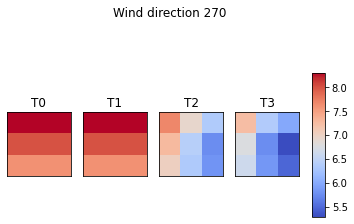

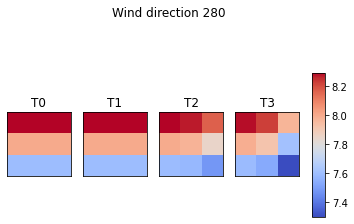

In [10]:
from floris.tools.visualization import plot_rotor_values

fig, _, _ , _ = plot_rotor_values(fi.floris.flow_field.u, findex=0, n_rows=1, n_cols=4, return_fig_objects=True)
fig.suptitle("Wind direction 270")

fig, _, _ , _ = plot_rotor_values(fi.floris.flow_field.u, findex=1, n_rows=1, n_cols=4, return_fig_objects=True)
fig.suptitle("Wind direction 280")

plt.show()

## On Grid Points

In FLORIS, grid points are the points in space where the wind conditions are calculated.
In a typical simulation, these are all located on a regular grid on each turbine rotor.

The parameter `turbine_grid_points` specifies the number of rows and columns which define the turbine grid.
In the example inputs, this value is 3 meaning there are 3 x 3 = 9 total grid points for each turbine.
Wake steering codes currently require greater values greater than 1 in order to compute gradients.
However, a single grid point (1 x 1) may be suitable for non wind farm control applications,
but retuning of some parameters might be required.

We can visualize the locations of the grid points in the current example using `matplotlib.pyplot`.

shape of xs: (2, 4, 3, 3)
  2 wd x 2 ws x 4 turbines x 3 x 3 grid points


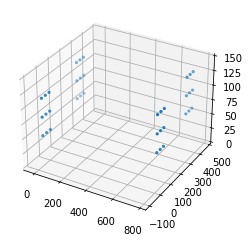

In [11]:
# Get the grid points
xs = fi.floris.grid.x_sorted
ys = fi.floris.grid.y_sorted
zs = fi.floris.grid.z_sorted

# Consider the shape
print(f"shape of xs: {xs.shape}")
print("  2 wd x 2 ws x 4 turbines x 3 x 3 grid points")

# Lets plot just one wd/ws conditions
xs = xs[1, :, :, :]
ys = ys[1, :, :, :]
zs = zs[1, :, :, :]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter(xs, ys, zs, marker=".")
ax.set_zlim([0, 150])

plt.show()

## Calculating AEP

FLORIS leverages vectorized operations on the CPU to reduce the computation
time for bulk calculations, and this is especially meaningful for calculating
annual energy production (AEP) on a wind rose.
Here, we demonstrate a simple AEP calculation for a 25-turbine farm
using several different modeling options. We make the assumption
that every wind speed and direction is equally likely. We also
report the time required for the computation using the Python
`time.perf_counter()` function.

In [12]:
import time
from typing import Tuple

# Using Numpy.meshgrid, we can combine 1D arrays of wind speeds and wind directions to produce
# combinations of both. Though the input arrays are not the same size, the resulting arrays
# will be the same size.
wind_directions, wind_speeds = np.meshgrid(
    np.arange(0.0, 360.0, 5),   # wind directions 0 to 360 degrees (exclusive) in 5 degree increments
    np.arange(8.0, 12.0, 0.2),  # wind speeds from 8 to 12 m/s in 0.2 m/s increments
    indexing="ij"
)
# meshgrid returns arrays with shape (len(wind_speeds), len(wind_directions)), so we "flatten" them
wind_directions = wind_directions.flatten()
wind_speeds = wind_speeds.flatten()

n_findex = len(wind_directions)
print(f"Calculating AEP for {n_findex} wind direction and speed combinations...")

# Set up a square 25 turbine layout
N = 5  # Number of turbines per row and per column
D = 126.0

# Create the turbine locations using the same method as above
x, y = np.meshgrid(
    7.0 * D * np.arange(0, N, 1),
    7.0 * D * np.arange(0, N, 1),
)
x = x.flatten()
y = y.flatten()
print(f"Number of turbines = {len(x)}")

# Define several models
fi_jensen = FlorisInterface("jensen.yaml")
fi_gch = FlorisInterface("gch.yaml")
fi_cc = FlorisInterface("cc.yaml")

# Assign the layouts, wind speeds and directions
fi_jensen.reinitialize(layout_x=x, layout_y=y, wind_directions=wind_directions, wind_speeds=wind_speeds)
fi_gch.reinitialize(layout_x=x, layout_y=y, wind_directions=wind_directions, wind_speeds=wind_speeds)
fi_cc.reinitialize(layout_x=x, layout_y=y, wind_directions=wind_directions, wind_speeds=wind_speeds)

def time_model_calculation(model_fi: FlorisInterface) -> Tuple[float, float]:
    """
    This function performs the wake calculation for a given
    FlorisInterface object and computes the AEP while
    tracking the amount of wall-time required for both steps.

    Args:
        model_fi (FlorisInterface): _description_
        float (_type_): _description_

    Returns:
        tuple(float, float):
            0: AEP
            1: Wall-time for the computation
    """
    start = time.perf_counter()
    model_fi.calculate_wake()
    aep = model_fi.get_farm_power().sum() / n_findex  / 1E9 * 365 * 24
    end = time.perf_counter()
    return aep, end - start

jensen_aep, jensen_compute_time = time_model_calculation(fi_jensen)
gch_aep, gch_compute_time = time_model_calculation(fi_gch)
cc_aep, cc_compute_time = time_model_calculation(fi_cc)

print('Model    AEP (GWh)  Compute Time (s)')
print('{:8s} {:<10.3f} {:<6.3f}'.format("Jensen", jensen_aep, jensen_compute_time))
print('{:8s} {:<10.3f} {:<6.3f}'.format("GCH", gch_aep, gch_compute_time))
print('{:8s} {:<10.3f} {:<6.3f}'.format("CC", cc_aep, cc_compute_time))

Calculating AEP for 1440 wind direction and speed combinations...
Number of turbines = 25
Model    AEP (GWh)  Compute Time (s)
Jensen   643.122    1.179 
GCH      646.972    3.742 
CC       633.776    6.833 


## Wake Steering Design

FLORIS includes a set of optimization routines for the design of wake steering controllers.
`SerialRefine` is a new method for quickly identifying optimum yaw angles.

In [13]:
# Demonstrate on 7-turbine single row farm
x = np.linspace(0, 6*7*D, 7)
y = np.zeros_like(x)
wind_directions = np.arange(0.0, 360.0, 2.0)
wind_speeds = 8.0 * np.ones_like(wind_directions)
fi_gch.reinitialize(layout_x=x, layout_y=y, wind_directions=wind_directions, wind_speeds=wind_speeds)

In [14]:
from floris.tools.optimization.yaw_optimization.yaw_optimizer_sr import YawOptimizationSR

# Define the SerialRefine optimization
yaw_opt = YawOptimizationSR(
    fi=fi_gch,
    minimum_yaw_angle=0.0,  # Allowable yaw angles lower bound
    maximum_yaw_angle=25.0,  # Allowable yaw angles upper bound
    Ny_passes=[5, 4],
    exclude_downstream_turbines=True,
    exploit_layout_symmetry=True,
)

UserWarning: Variable input must have shape (n_wind_directions, n_wind_speeds, nturbs)

In [ ]:
start = time.perf_counter()

## Calculate the optimum yaw angles for 25 turbines and 72 wind directions
df_opt = yaw_opt.optimize()

end = time.perf_counter()

walltime = end - start
print(f"Optimization wall time: {walltime:.3f} s")


In the results, T0 is the upstream turbine when wind direction is 270, while T6 is upstream at 90 deg

In [ ]:
# Show the results
yaw_angles_opt = np.vstack(df_opt["yaw_angles_opt"])
fig, axarr = plt.subplots(len(x), 1, sharex=True, sharey=True, figsize=(10, 10))
for i in range(len(x)):
    axarr[i].plot(wind_directions, yaw_angles_opt[:, i], 'k-', label='T%d' % i)
    axarr[i].set_ylabel('Yaw (Deg)')
    axarr[i].legend()
    axarr[i].grid(True)
axarr[-1].set_xlabel('Wind Direction (Deg)')

plt.show()